In [2]:
! pip install -qU datasets ragas langchain langchain-mongodb langchain-openai \
pymongo pandas tqdm matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.3/178.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.2

In [3]:
import getpass
import os

from openai import OpenAI

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
openai_client = OpenAI()

Enter your OpenAI API Key:··········


In [5]:
MONGODB_URI = getpass.getpass("Enter your MongoDB connection string:")

Enter your MongoDB connection string:··········


In [6]:
import pandas as pd
from datasets import load_dataset

In [7]:
data = load_dataset("explodinggradients/ragas-wikiqa", split="train")
df = pd.DataFrame(data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/621 [00:00<?, ?B/s]

(…)-00000-of-00001-78b16d7ae6b9b0f1.parquet:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/232 [00:00<?, ? examples/s]

In [8]:
df.head(1)

,question,correct_answer,incorrect_answer,question_id,generated_with_rag,context,generated_without_rag
0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,"As such, African immigrants are to be distingu...",From the Immigration and Nationality Act of 19...,Q0,\nAfrican Americans were immigrated to the Uni...,[African immigration to the United States refe...,African Americans were immigrated to the US in...


In [9]:
len(df)

232

In [10]:
from typing import List

from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
# Split text by tokens using the tiktoken tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", keep_separator=False, chunk_size=200, chunk_overlap=30
)

In [12]:
def split_texts(texts: List[str]) -> List[str]:
    """
    Split large texts into chunks

    Args:
        texts (List[str]): List of reference texts

    Returns:
        List[str]: List of chunked texts
    """
    chunked_texts = []
    for text in texts:
        chunks = text_splitter.create_documents([text])
        chunked_texts.extend([chunk.page_content for chunk in chunks])
    return chunked_texts

In [13]:
# Split the context field into chunks
df["chunks"] = df["context"].apply(lambda x: split_texts(x))

In [14]:
# Aggregate list of all chunks
all_chunks = df["chunks"].tolist()
docs = [item for chunk in all_chunks for item in chunk]

In [15]:
len(docs)

3795

In [16]:
docs[100]

'Figgis had problems because permits were not issued for some street scenes. This caused him to film some scenes on the Las Vegas strip in one take to avoid the police, which Figgis said benefited production and the authenticity of the acting, remarking "I\'ve always hated the convention of shooting on a street, and then having to stop the traffic, and then having to tell the actors, \'Well, there\'s meant to be traffic here, so you\'re going to have to shout.\' And they\'re shouting, but it\'s quiet and they feel really stupid, because it\'s unnatural. You put them up against a couple of trucks, with it all happening around them, and their voices become great". Filming took place over 28 days.'

In [17]:
from pymongo import MongoClient
from pymongo.errors import ServerSelectionTimeoutError
from tqdm.auto import tqdm

In [18]:
def get_embeddings(docs: List[str], model: str) -> List[List[float]]:
    """
    Generate embeddings using the OpenAI API.

    Args:
        docs (List[str]): List of texts to embed
        model (str, optional): Model name. Defaults to "text-embedding-3-large".

    Returns:
        List[float]: Array of embeddings
    """
    # replace newlines, which can negatively affect performance.
    docs = [doc.replace("\n", " ") for doc in docs]
    response = openai_client.embeddings.create(input=docs, model=model)
    response = [r.embedding for r in response.data]
    return response

In [19]:
client = MongoClient(MONGODB_URI, appname="devrel.content.python", ssl=True)
DB_NAME = "ragas_evals"
db = client[DB_NAME]

In [20]:
batch_size = 128

In [21]:
EVAL_EMBEDDING_MODELS = ["text-embedding-ada-002", "text-embedding-3-small"]

In [22]:
for model in EVAL_EMBEDDING_MODELS:
    embedded_docs = []
    print(f"Getting embeddings for the {model} model")
    for i in tqdm(range(0, len(docs), batch_size)):
        end = min(len(docs), i + batch_size)
        batch = docs[i:end]
        # Generate embeddings for current batch
        batch_embeddings = get_embeddings(batch, model)
        # Creating the documents to ingest into MongoDB for current batch
        batch_embedded_docs = [
            {"text": batch[i], "embedding": batch_embeddings[i]}
            for i in range(len(batch))
        ]
        embedded_docs.extend(batch_embedded_docs)
    print(f"Finished getting embeddings for the {model} model")

    # Bulk insert documents into a MongoDB collection
    print(f"Inserting embeddings for the {model} model")
    collection = db[model]

    # Add a try-except block to handle ServerSelectionTimeoutError
    try:
        collection.delete_many({})
        collection.insert_many(embedded_docs)
    except ServerSelectionTimeoutError as e:
        print(f"Error connecting to MongoDB: {e}")
        # Add any desired error handling logic here,
        # such as retrying the connection or exiting the program.
        # For example, to retry after 5 seconds:
        # import time
        # time.sleep(5)
        # continue  # Retry the current iteration


    print(f"Finished inserting embeddings for the {model} model")

Getting embeddings for the text-embedding-ada-002 model


  0%|          | 0/30 [00:00<?, ?it/s]

Finished getting embeddings for the text-embedding-ada-002 model
Inserting embeddings for the text-embedding-ada-002 model
Finished inserting embeddings for the text-embedding-ada-002 model
Getting embeddings for the text-embedding-3-small model


  0%|          | 0/30 [00:00<?, ?it/s]

Finished getting embeddings for the text-embedding-3-small model
Inserting embeddings for the text-embedding-3-small model
Finished inserting embeddings for the text-embedding-3-small model


In [23]:
import nest_asyncio
from datasets import Dataset
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_openai import OpenAIEmbeddings
from ragas import RunConfig, evaluate
from ragas.metrics import context_precision, context_recall

# Allow nested use of asyncio (used by RAGAS)
nest_asyncio.apply()

In [24]:
def get_retriever(model: str, k: int) -> VectorStoreRetriever:
    """
    Given an embedding model and top k, get a vector store retriever object

    Args:
        model (str): Embedding model to use
        k (int): Number of results to retrieve

    Returns:
        VectorStoreRetriever: A vector store retriever object
    """
    embeddings = OpenAIEmbeddings(model=model)

    vector_store = MongoDBAtlasVectorSearch.from_connection_string(
        connection_string=MONGODB_URI,
        namespace=f"{DB_NAME}.{model}",
        embedding=embeddings,
        index_name="vector_index",
        text_key="text",
    )

    retriever = vector_store.as_retriever(
        search_type="similarity", search_kwargs={"k": k}
    )
    return retriever

In [25]:
QUESTIONS = df["question"].to_list()
GROUND_TRUTH = df["correct_answer"].tolist()

In [26]:
for model in EVAL_EMBEDDING_MODELS:
    data = {"question": [], "ground_truth": [], "contexts": []}
    data["question"] = QUESTIONS
    data["ground_truth"] = GROUND_TRUTH

    retriever = get_retriever(model, 2)
    # Getting relevant documents for the evaluation dataset
    for question in tqdm(QUESTIONS):
        data["contexts"].append(
            [doc.page_content for doc in retriever.get_relevant_documents(question)]
        )
    # RAGAS expects a Dataset object
    dataset = Dataset.from_dict(data)
    # RAGAS runtime settings to avoid hitting OpenAI rate limits
    run_config = RunConfig(max_workers=4, max_wait=180)
    result = evaluate(
        dataset=dataset,
        metrics=[context_precision, context_recall],
        run_config=run_config,
        raise_exceptions=False,
    )
    print(f"Result for the {model} model: {result}")

  0%|          | 0/232 [00:00<?, ?it/s]

<ipython-input-26-d778ac6cf9ac>:10: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  [doc.page_content for doc in retriever.get_relevant_documents(question)]


Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Result for the text-embedding-ada-002 model: {'context_precision': 0.6853, 'context_recall': 0.6846}


  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Result for the text-embedding-3-small model: {'context_precision': 0.6681, 'context_recall': 0.6800}


In [27]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.base import RunnableSequence
from langchain_openai import ChatOpenAI
from ragas.metrics import answer_relevancy, faithfulness

In [28]:
def get_rag_chain(retriever: VectorStoreRetriever, model: str) -> RunnableSequence:
    """
    Create a basic RAG chain

    Args:
        retriever (VectorStoreRetriever): Vector store retriever object
        model (str): Chat completion model to use

    Returns:
        RunnableSequence: A RAG chain
    """
    # Generate context using the retriever, and pass the user question through
    retrieve = {
        "context": retriever
        | (lambda docs: "\n\n".join([d.page_content for d in docs])),
        "question": RunnablePassthrough(),
    }
    template = """Answer the question based only on the following context: \
    {context}

    Question: {question}
    """
    # Defining the chat prompt
    prompt = ChatPromptTemplate.from_template(template)
    # Defining the model to be used for chat completion
    llm = ChatOpenAI(temperature=0, model=model)
    # Parse output as a string
    parse_output = StrOutputParser()

    # Naive RAG chain
    rag_chain = retrieve | prompt | llm | parse_output
    return rag_chain

In [29]:
for model in ["gpt-3.5-turbo-1106", "gpt-3.5-turbo"]:
    data = {"question": [], "ground_truth": [], "contexts": [], "answer": []}
    data["question"] = QUESTIONS
    data["ground_truth"] = GROUND_TRUTH
    # Using the best embedding model from the retriever evaluation
    retriever = get_retriever("text-embedding-3-small", 2)
    rag_chain = get_rag_chain(retriever, model)
    for question in tqdm(QUESTIONS):
        data["answer"].append(rag_chain.invoke(question))
        data["contexts"].append(
            [doc.page_content for doc in retriever.get_relevant_documents(question)]
        )
    # RAGAS expects a Dataset object
    dataset = Dataset.from_dict(data)
    # RAGAS runtime settings to avoid hitting OpenAI rate limits
    run_config = RunConfig(max_workers=4, max_wait=180)
    result = evaluate(
        dataset=dataset,
        metrics=[faithfulness, answer_relevancy],
        run_config=run_config,
        raise_exceptions=False,
    )
    print(f"Result for the {model} model: {result}")

  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Result for the gpt-3.5-turbo-1106 model: {'faithfulness': 0.8445, 'answer_relevancy': 0.8869}


  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Result for the gpt-3.5-turbo model: {'faithfulness': 0.8349, 'answer_relevancy': 0.8879}


In [30]:
from ragas.metrics import answer_correctness, answer_similarity

In [31]:
data = {"question": [], "ground_truth": [], "answer": []}
data["question"] = QUESTIONS
data["ground_truth"] = GROUND_TRUTH
# Using the best embedding model from the retriever evaluation
retriever = get_retriever("text-embedding-3-small", 2)
# Using the best completion model from the generator evaluation
rag_chain = get_rag_chain(retriever, "gpt-3.5-turbo")
for question in tqdm(QUESTIONS):
    data["answer"].append(rag_chain.invoke(question))

dataset = Dataset.from_dict(data)
run_config = RunConfig(max_workers=4, max_wait=180)
result = evaluate(
    dataset=dataset,
    metrics=[answer_similarity, answer_correctness],
    run_config=run_config,
    raise_exceptions=False,
)
print(f"Overall metrics: {result}")

  0%|          | 0/232 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/464 [00:00<?, ?it/s]

Overall metrics: {'semantic_similarity': 0.8901, 'answer_correctness': 0.5317}


In [32]:
result_df = result.to_pandas()

In [33]:
result_df.head(5)

,user_input,response,reference,semantic_similarity,answer_correctness
0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,African Americans were involuntarily brought f...,"As such, African immigrants are to be distingu...",0.913579,0.828374
1,what are points on a mortgage,Points on a mortgage are a form of pre-paid in...,"Points, sometimes also called a ""discount poin...",0.914058,0.442800
2,how does interlibrary loan work,Interlibrary loan works by allowing patrons of...,The user makes a request with their local libr...,0.884037,0.689777
3,WHAT IS A FY QUARTER,A FY quarter in Australia would refer to a qua...,"A fiscal year (or financial year, or sometimes...",0.850264,0.426852
4,who wrote a rose is a rose is a rose,Gertrude Stein,"The sentence ""Rose is a rose is a rose is a ro...",0.868210,0.592053


In [34]:
result_df[result_df["answer_correctness"] < 0.7]

,user_input,response,reference,semantic_similarity,answer_correctness
1,what are points on a mortgage,Points on a mortgage are a form of pre-paid in...,"Points, sometimes also called a ""discount poin...",0.914058,0.442800
2,how does interlibrary loan work,Interlibrary loan works by allowing patrons of...,The user makes a request with their local libr...,0.884037,0.689777
3,WHAT IS A FY QUARTER,A FY quarter in Australia would refer to a qua...,"A fiscal year (or financial year, or sometimes...",0.850264,0.426852
4,who wrote a rose is a rose is a rose,Gertrude Stein,"The sentence ""Rose is a rose is a rose is a ro...",0.868210,0.592053
7,who played the lead roles in the movie leaving...,Nicolas Cage and Elisabeth Shue,Nicolas Cage stars as a suicidal alcoholic who...,0.842312,0.585511
...,...,...,...,...,...
227,What happened during the Starving Time in Jame...,"During the Starving Time in Jamestown, there w...",There is scientific evidence that the settlers...,0.892011,0.223003
228,what food is in afghan,"mutton, beef, poultry, fish, rice, Afghan brea...",Accompanying these staples are dairy products ...,0.894566,0.504892
229,how kimberlite pipes form,Kimberlite pipes form when an eruption ejects ...,Volcanic pipes are relatively rare.,0.818167,0.204542
230,what county is coatesville indiana located in,"Coatesville, Indiana is located in Hendricks C...","Coatesville is a town in Clay Township , Hendr...",0.957239,0.489310


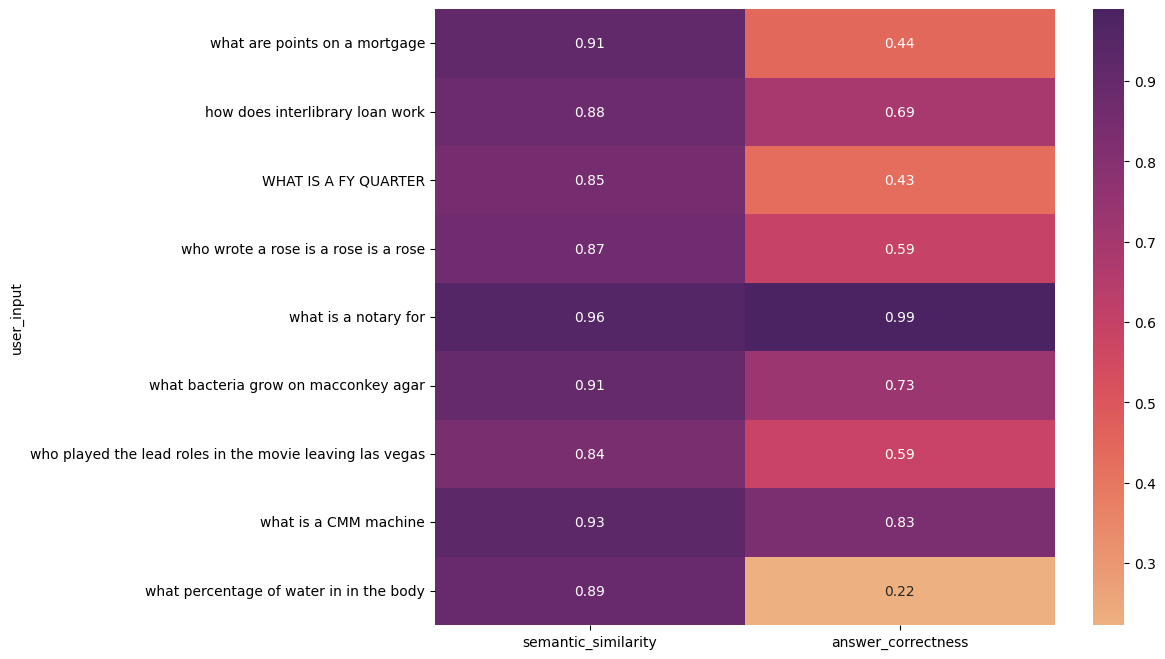

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
# Access metrics data from the nested structure
heatmap_data = result_df.reset_index().iloc[1:10]

# Access the metric values directly using the function names as column names
# Use .name instead of .__name__
heatmap_data = heatmap_data[[answer_similarity.name, answer_correctness.name]]

# Set 'user_input' as index for the heatmap
heatmap_data = heatmap_data.set_index(result_df.reset_index().iloc[1:10]['user_input'])

sns.heatmap(heatmap_data, annot=True, cmap="flare")
plt.show()